In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt


In [4]:
merged = pd.read_csv("/Users/ayush/Library/Mobile Documents/com~apple~CloudDocs/Developer/UIDAI/02_Cleaned_Data/merged.csv")

print(merged.shape)
merged.head()


(4398, 18)


,state,district,year,month,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_,bio_age_5_17,bio_age_17_,total_enrolments,total_updates,adult_system_stress,child_system_stress,digital_friction_index,log_digital_friction,friction_outlier
0,Andaman and Nicobar Islands,nicobar,2025,9,42,6,0,2.0,116.0,92.0,148.0,48,358.0,264.0,94.0,264.0,5.579730,False
1,Andaman and Nicobar Islands,nicobar,2025,10,6,4,0,6.0,39.0,29.0,55.0,10,129.0,94.0,35.0,94.0,4.553877,False
2,Andaman and Nicobar Islands,nicobar,2025,11,11,0,0,4.0,82.0,116.0,54.0,11,256.0,136.0,120.0,136.0,4.919981,False
3,Andaman and Nicobar Islands,nicobar,2025,12,5,1,0,6.0,52.0,203.0,51.0,6,312.0,103.0,209.0,103.0,4.644391,False
4,Andaman and Nicobar Islands,north and middle andaman,2025,9,38,2,0,8.0,167.0,531.0,175.0,40,881.0,342.0,539.0,342.0,5.837730,False


In [16]:
outliers = pd.read_csv("/Users/ayush/Library/Mobile Documents/com~apple~CloudDocs/Developer/UIDAI/Outputs/high_friction_outliers.csv")

merged['high_friction_label'] = 0
merged.loc[merged.index.isin(outliers.index), 'high_friction_label'] = 1

merged['high_friction_label'].value_counts(normalize=True)


high_friction_label
0    0.949977
1    0.050023
Name: proportion, dtype: float64

In [ ]:
# FEATURE SELECTION

features = [
    'total_enrolments',
    'total_updates',
    'adult_system_stress',
    'child_system_stress',
    'age_18_greater',
    'demo_age_5_17',
    'bio_age_5_17',
    'month'
]

X = merged[features]
y = merged['high_friction_label']


In [ ]:
# train-test split with stratification

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [ ]:
# Model training with XGBoost

model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [ ]:
# Model evaluation

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       836
           1       0.51      0.61      0.56        44

    accuracy                           0.95       880
   macro avg       0.74      0.79      0.77       880
weighted avg       0.96      0.95      0.95       880

ROC-AUC: 0.9422303175293605


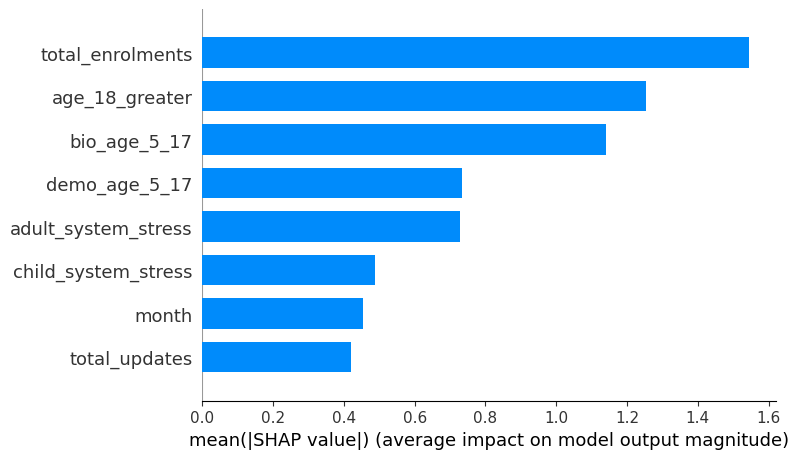

In [ ]:
# SHAP explainability

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


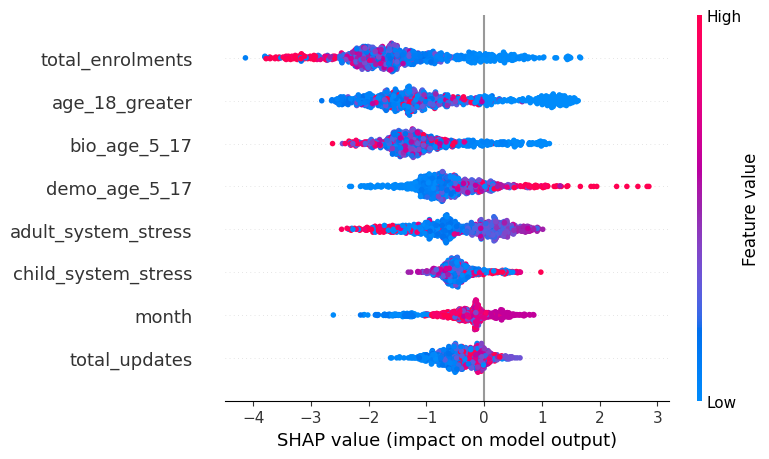

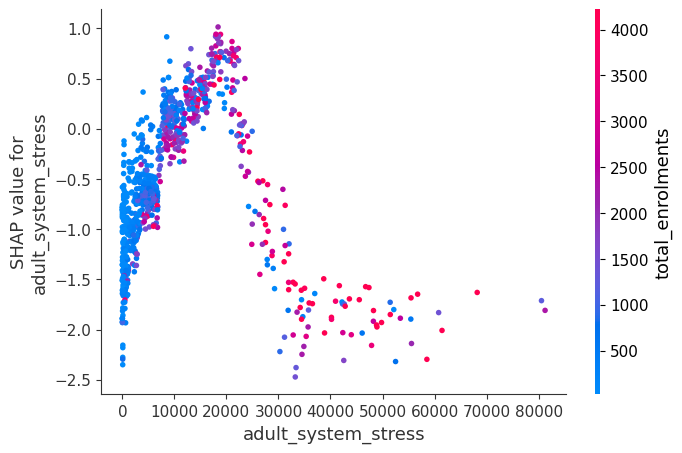

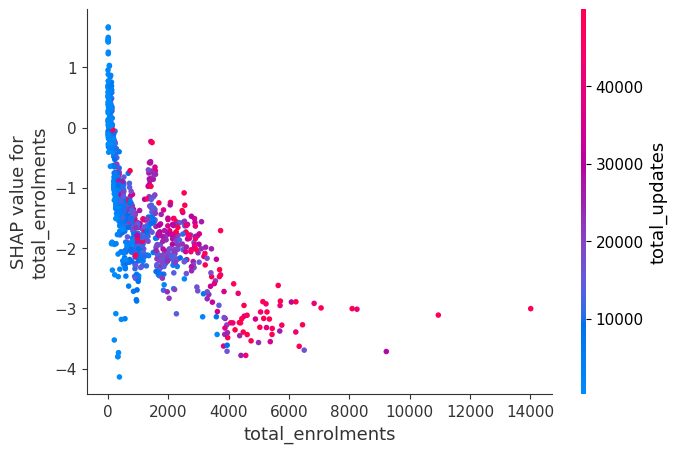

In [ ]:
# SHAP plots

shap.summary_plot(shap_values, X_test)
shap.dependence_plot("adult_system_stress", shap_values, X_test)
shap.dependence_plot("total_enrolments", shap_values, X_test)

In [ ]:
# Save SHAP plots

import os
os.makedirs("../outputs/shap_plots", exist_ok=True)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig("../outputs/shap_plots/shap_global_bar.png", dpi=300)
plt.close()

shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("../outputs/shap_plots/shap_beeswarm.png", dpi=300)
plt.close()


In [ ]:
# Create risk table

risk_table = X_test.copy()
risk_table['risk_score'] = y_prob
risk_table['predicted_high_friction'] = (y_prob > 0.6).astype(int)

risk_table.sort_values('risk_score', ascending=False).head(10)


,total_enrolments,total_updates,adult_system_stress,child_system_stress,age_18_greater,demo_age_5_17,bio_age_5_17,month,risk_score,predicted_high_friction
4286,2,0.0,0.0,0.0,0,0.0,0.0,9,0.983939,1
1788,10,1.0,1.0,0.0,0,0.0,0.0,11,0.980257,1
152,47,207.0,204.0,3.0,0,3.0,0.0,10,0.979604,1
53,2525,52152.0,23558.0,28594.0,19,2750.0,25844.0,11,0.976174,1
75,14,0.0,0.0,0.0,0,0.0,0.0,11,0.974702,1
154,19,334.0,325.0,9.0,0,9.0,0.0,12,0.972611,1
236,9,0.0,0.0,0.0,0,0.0,0.0,10,0.971945,1
100,64,4938.0,3983.0,955.0,0,173.0,782.0,12,0.964071,1
138,27,0.0,0.0,0.0,0,0.0,0.0,9,0.960151,1
148,193,9692.0,8526.0,1166.0,0,227.0,939.0,10,0.957097,1


In [14]:
risk_table.to_csv("../outputs/risk_predictions.csv", index=False)


In [ ]:
# Feature importance table

importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

importance.to_csv(
    "../outputs/feature_importance.csv",
    index=False
)
